# Schelling's segregation model

Source: [`Agents.jl` tutorial](https://juliadynamics.github.io/Agents.jl/stable/tutorial/). [Wikipedia](https://en.wikipedia.org/wiki/Schelling%27s_model_of_segregation)

- Agents : They belong to one of two groups (0 or 1).
- Model : Each position of the grid can be occupied by at most one agent.
- For each step
  - If an agent has at least 3 neighbors belonging to the same group, then it is happy.
  - If an agent is unhappy, it keeps moving to new locations until it is happy.

To define an agent type, we should make a mutable struct derived from `AbstractAgent` with 2 mandatory fields:
- `id::Int` . The identifier number of the agent.
- `pos` . For agents on a 2D grid, the position field should be a tuple of 2 integers.

On top of that, we could define other properties for the agents.

## Setup

First, we create a 2D space with a Chebyshev metric. This leads to *8 neighboring positions* per position (except at the edges of the grid).

In [1]:
using Agents
using Random
using CairoMakie
CairoMakie.activate!(px_per_unit = 1.0)


Update message: Agents v6

This is a new major version of Agents.jl with lots of cool stuff!
However, from this version onwards, we will stop posting update messages
to the REPL console!

If you want to be updated, follow this discourse post:

https://discourse.julialang.org/t/agents-jl-v6-releases-announcement-post/111678

(and see the CHANGELOG.md file online for a list of changes!)


The helper function below is adapted from `Agents.abmvideo` and correctly displays animations in Jupyter notebooks

In [2]:
function abmvio(model;
    dt = 1, framerate = 30, frames = 300, title = "", showstep = true,
    figure = (size = (600, 600),), axis = NamedTuple(),
    recordkwargs = (compression = 23, format ="mp4"), kwargs...
)
    # title and steps
    abmtime_obs = Observable(abmtime(model))
    if title ≠ "" && showstep
        t = lift(x -> title*", time = "*string(x), abmtime_obs)
    elseif showstep
        t = lift(x -> "time = "*string(x), abmtime_obs)
    else
        t = title
    end

    axis = (title = t, titlealign = :left, axis...)
    # First frame
    fig, ax, abmobs = abmplot(model; add_controls = false, warn_deprecation = false, figure, axis, kwargs...)
    resize_to_layout!(fig)
    # Animation
    Makie.Record(fig; framerate, recordkwargs...) do io
        for j in 1:frames-1
            recordframe!(io)
            Agents.step!(abmobs, dt)
            abmtime_obs[] = abmtime(model)
        end
        recordframe!(io)
    end
end

abmvio (generic function with 1 method)

Define the Agent type using the [`@agent`](https://juliadynamics.github.io/Agents.jl/stable/api/#Agents.@agent) macro.
The agents inherit all properties of `GridAgent{2}` sicne they live on a 2D grid. They also have two properties: `mood` (happy or not) and `group`.

In [3]:
@agent struct SchellingAgent(GridAgent{2})
    mood::Bool = false ## true = happy
    group::Int ## the group does not have a default value!
end

Define the stepping function for the agent `nearby_agents(agent, model)` lists neighbors.
If there are over 2 neighbors of the same group, make the agent happy.
Else,  the agent will move to a random empty position

In [4]:
function schelling_step!(agent::SchellingAgent, model)
    minhappy = model.min_to_be_happy
    count_neighbors_same_group = 0
    for neighbor in nearby_agents(agent, model)
        if agent.group == neighbor.group
            count_neighbors_same_group += 1
        end
    end
    if count_neighbors_same_group ≥ minhappy
        agent.mood = true ## The agent is happy
    else
        agent.mood = false
        move_agent_single!(agent, model) ## Move the agent to a random position
    end
    return nothing
end

schelling_step! (generic function with 1 method)

It is recommended to use a function to create the ABM for easily alter its parameters.

In [5]:
function init_schelling(; numagents = 300, griddims = (20, 20), min_to_be_happy = 3, seed = 2024)
    # Create a space for the agents to reside
    space = GridSpace(griddims)
    # Define parameters of the ABM
    properties = Dict(:min_to_be_happy => min_to_be_happy)
    rng = Random.Xoshiro(seed)
    # Create the model
    model = StandardABM(
        SchellingAgent, space;
        properties, rng,
        agent_step! = schelling_step!,
        container = Vector, ## agents are not removed, this is faster
        scheduler = Schedulers.Randomly()
    )

    # Populate the model with agents, adding equal amount of the two types of agents at random positions in the model.
    # We don't have to set the starting position. Agents.jl will choose a random position.
    for n in 1:numagents
        add_agent_single!(model; group = n < 300 / 2 ? 1 : 2)
    end
    return model
end

init_schelling (generic function with 1 method)

## Running the model

In [6]:
model = init_schelling()

StandardABM with 300 agents of type SchellingAgent
 agents container: Vector
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: Agents.Schedulers.Randomly
 properties: min_to_be_happy

The `step!()` function evolves the model forward. The `run!()` function is similar to `step!()` but also collects data along the simulation.
Progress the model by one step.

In [7]:
step!(model)

StandardABM with 300 agents of type SchellingAgent
 agents container: Vector
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: Agents.Schedulers.Randomly
 properties: min_to_be_happy

Progress the model by 3 steps

In [8]:
step!(model, 3)

StandardABM with 300 agents of type SchellingAgent
 agents container: Vector
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: Agents.Schedulers.Randomly
 properties: min_to_be_happy

Progress the model until 90% of the agents are happy

In [9]:
happy90(model, time) = count(a -> a.mood == true, allagents(model))/nagents(model) ≥ 0.9
step!(model, happy90)

StandardABM with 300 agents of type SchellingAgent
 agents container: Vector
 space: GridSpace with size (20, 20), metric=chebyshev, periodic=true
 scheduler: Agents.Schedulers.Randomly
 properties: min_to_be_happy

How many steps are passed

In [10]:
abmtime(model)

4

## Visualization
The `abmplot()` function visulizes the simulation result using Makie.jl.
Some helper functions to identify agent groups.

In [11]:
groupcolor(a) = a.group == 1 ? :blue : :orange
groupmarker(a) = a.group == 1 ? :circle : :rect

groupmarker (generic function with 1 method)

Plot the initial conditions of the model

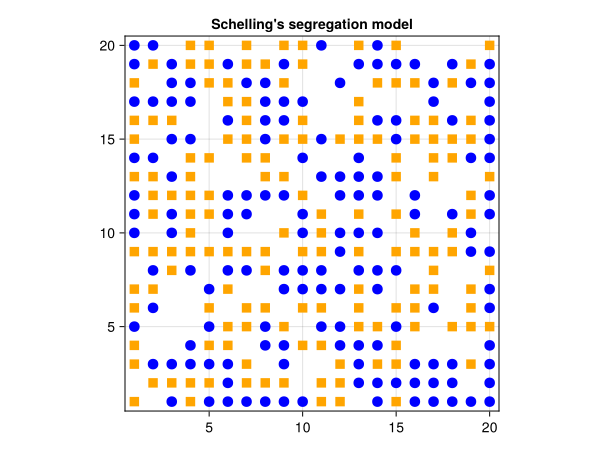

In [12]:
model = init_schelling()
figure, _ = abmplot(model; agent_color = groupcolor, agent_marker = groupmarker, agent_size = 15, axis=(;title = "Schelling's segregation model"))
figure

Let's make an animation for the model evolution.

In [13]:
model = init_schelling()
vio = abmvio(model;
    agent_color = groupcolor,
    agent_marker = groupmarker,
    agent_size = 15,
    framerate = 4, frames = 20,
    title = "Schelling's segregation model"
)

vio |> display

Makie.VideoStream(Base.PipeEndpoint(RawFD(24) open, 0 bytes waiting), Process(setenv(`/home/runner/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin/ffmpeg -y -loglevel quiet -threads 4 -framerate 4 -pixel_format rgb24 -f rawvideo -s:v 600x600 -r 4 -i pipe:0 -vf vflip -profile:v high422 -crf 23 -preset slow -c:v libx264 -pix_fmt yuv420p -an '/tmp/jl_VH2fpx/##video#231.mp4'`,["JULIA_CI=true", "PATH=/home/runner/.julia/artifacts/b8a470e4553346122607f94ec60d83c77f061cd6/bin:/home/runner/.julia/artifacts/7f882b869c126a717e15be05453b83bd9135eab0/bin:/home/runner/.julia/artifacts/96bc7b9ddb319d1a051535c85184aa2bf42dbd8b/bin:/home/runner/.julia/artifacts/2a6bae048c28452d329375cbb7479499115e45ad/bin:/home/runner/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/bin:/home/runner/.julia/artifacts/0b5269206a6849e48487ed04136c30b1f12443e7/bin:/home/runner/.julia/artifacts/bdb4015047b09c6ac5002f73dfd5be8ddf59189b/bin:/home/runner/.julia/artifacts/00023f2f62a04af7531278ce1a689ff93800ffa1/bin:/home/runner/.julia/artifacts/a696e1e3e6b8d3c2c4b67609357ebc5c35eabde1/bin:/home/runner/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin:/opt/hostedtoolcache/julia/1.11.5/x64/bin:/opt/hostedtoolcache/uv/0.7.13/x86_64:/home/runner/.local/bin:/opt/hostedtoolcache/Python/3.13.5/x64/bin:/opt/hostedtoolcache/Python/3.13.5/x64:/snap/bin:/home/runner/.local/bin:/opt/pipx_bin:/home/runner/.cargo/bin:/home/runner/.config/composer/vendor/bin:/usr/local/.ghcup/bin:/home/runner/.dotnet/tools:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin", "DOTNET_SKIP_FIRST_TIME_EXPERIENCE=1", "GITHUB_RUN_NUMBER=632", "GITHUB_REF_NAME=main", "RUNNER_ARCH=X64", "LD_LIBRARY_PATH=/home/runner/.julia/artifacts/715b660f53eb83c33e199a44ececfd8dc03f2a27/lib:/opt/hostedtoolcache/julia/1.11.5/x64/bin/../lib/julia:/home/runner/.julia/artifacts/94475b26c9b6ff3bed68391232c55fd81a4a64b4/lib:/home/runner/.julia/artifacts/b8a470e4553346122607f94ec60d83c77f061cd6/lib:/home/runner/.julia/artifacts/5acd766faaca59c3c1f3cfa67e2bf6dcf1e3e883/lib:/home/runner/.julia/artifacts/d4c2f2966f2932e4870b0488c3b8a6b92b6641a9/lib:/home/runner/.julia/artifacts/7f882b869c126a717e15be05453b83bd9135eab0/lib:/home/runner/.julia/artifacts/dc526f26fb179a3f68eb13fcbe5d2d2a5aa7eeac/lib:/home/runner/.julia/artifacts/1d90be1fb2a7f5023513bdcbb8abf7727ded6044/lib:/home/runner/.julia/artifacts/f8704eb01ec7508ae1f125b7ff89647997ed80cb/lib:/home/runner/.julia/artifacts/e8574c15e0152044b131e5d6956374f4b0bacce7/lib:/home/runner/.julia/artifacts/0c4797c296c27a8877ac9b42c35986da71cd14c7/lib:/home/runner/.julia/artifacts/f5e52a42c85b68d1f7ee821d9d8c13a44c377956/lib:/home/runner/.julia/artifacts/96bc7b9ddb319d1a051535c85184aa2bf42dbd8b/lib:/home/runner/.julia/artifacts/2a6bae048c28452d329375cbb7479499115e45ad/lib:/home/runner/.julia/artifacts/0a1006d282bce91b5cd408c714cbb95d3bb4f515/lib:/home/runner/.julia/artifacts/59eff635528e6914e1a96db241e950195574903b/lib:/home/runner/.julia/artifacts/299dd9a174ebc497df2cf4d30f1c6d10948c60ef/lib:/home/runner/.julia/artifacts/f0557b9a3c2c4667444e8fc63c1fc9c2c5cb9e63/lib:/home/runner/.julia/artifacts/6da9d8475fd9fd2867e3bd1f46f3913c800a316f/lib:/home/runner/.julia/artifacts/a3f956e6772ef4da35e128fd2a4477cf16fd3c84/lib:/home/runner/.julia/artifacts/e2512e1cd411449b9bede7b4294c7409c9973345/lib:/home/runner/.julia/artifacts/ed48bfcf31d2d5ebdc0a681d1ed07e1e9f9f0377/lib:/home/runner/.julia/artifacts/eb13375496c29fe52101a0e6710c54ff87aa0e20/lib:/home/runner/.julia/artifacts/5c030ff72c13f84fbbc8f93a146e34c6219a0261/lib:/home/runner/.julia/artifacts/bd1f25e7053ebc00ee7d82f3c5ec4cf1e9a51e17/lib:/home/runner/.julia/artifacts/cf5d5f8a6109be3f9c460a39768f57a3e53ff11d/lib:/home/runner/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/lib:/home/runner/.julia/artifacts/0631e2a6a31b5692eec7a575836451b16b734ec0/lib:/home/runner/.julia/artifacts/4abd0521d210cb9e48ea5e711873ba34dc05fc70/lib:/home/runner/.julia/artifacts/0b52

## Data analysis
The `run!()` function runs simulation and collects data in the `DataFrame` format. The `adata` (aggregated data) keyword selects fields we want to extract in the DataFrame.

In [14]:
x(agent) = agent.pos[1]
adata = [x, :mood, :group]
model = init_schelling()
adf, mdf = run!(model, 5; adata)
adf[end-10:end, :] ## display only the last few rows

11×5 DataFrame
 Row │ time   id     x      mood   group 
     │ Int64  Int64  Int64  Bool   Int64 
─────┼───────────────────────────────────
   1 │     5    290     10   true      2
   2 │     5    291     19  false      2
   3 │     5    292      5   true      2
   4 │     5    293     16   true      2
   5 │     5    294     16   true      2
   6 │     5    295      6   true      2
   7 │     5    296      8   true      2
   8 │     5    297      7   true      2
   9 │     5    298     14   true      2
  10 │     5    299     11   true      2
  11 │     5    300     10   true      2

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*